# Reading in the data

In [1]:
import numpy as np
import csv
from PIL import Image
import matplotlib.pyplot
from os import listdir
from os.path import isfile, join
import math

In [2]:
train_im_dir = "../../data/train/images/"
train_data_dir = "../../data/train/train.csv"
w = 101
h = 101

Reading in the uique files

In [16]:
files = [f for f in listdir(train_im_dir) if isfile(join(train_im_dir, f))]

In [32]:
X = np.ndarray(shape = (0, 101, 101, 1))
for i in range (len (files)):
    im = Image.open(train_im_dir+files[i])
    if (im.mode == "RGB"):
        im = im.convert('L')
    pixels = np.array(list(im.getdata()))
    pixels = pixels.reshape((1, 101, 101, 1))
    X = np.concatenate((X, pixels), axis = 0)
    if (i % 50 == 0):
        print (str(i) + " / " + str(len(files)))
print(X.shape)


0 / 4000
50 / 4000
100 / 4000
150 / 4000
200 / 4000
250 / 4000
300 / 4000
350 / 4000
400 / 4000
450 / 4000
500 / 4000
550 / 4000
600 / 4000
650 / 4000
700 / 4000
750 / 4000
800 / 4000
850 / 4000
900 / 4000
950 / 4000
1000 / 4000
1050 / 4000
1100 / 4000
1150 / 4000
1200 / 4000
1250 / 4000
1300 / 4000
1350 / 4000
1400 / 4000
1450 / 4000
1500 / 4000
1550 / 4000
1600 / 4000
1650 / 4000
1700 / 4000
1750 / 4000
1800 / 4000
1850 / 4000
1900 / 4000
1950 / 4000
2000 / 4000
2050 / 4000
2100 / 4000
2150 / 4000
2200 / 4000
2250 / 4000
2300 / 4000
2350 / 4000
2400 / 4000
2450 / 4000
2500 / 4000
2550 / 4000
2600 / 4000
2650 / 4000
2700 / 4000
2750 / 4000
2800 / 4000
2850 / 4000
2900 / 4000
2950 / 4000
3000 / 4000
3050 / 4000
3100 / 4000
3150 / 4000
3200 / 4000
3250 / 4000
3300 / 4000
3350 / 4000
3400 / 4000
3450 / 4000
3500 / 4000
3550 / 4000
3600 / 4000
3650 / 4000
3700 / 4000
3750 / 4000
3800 / 4000
3850 / 4000
3900 / 4000
3950 / 4000
(4001, 101, 101, 1)


In [36]:
X.shape

(4000, 101, 101, 1)

In [72]:
ids = []
rle = []

full_path = 'C:/Users/Conner/Documents/Kaggle/TGS Salt/data/train.csv'
with open(full_path, 'r') as csvfile:
    fieldnames = ['id', 'rle_mask']
    reader = csv.DictReader(csvfile, fieldnames=fieldnames)
    for row in reader:
        ids.append(row['id'])
        rle.append(row['rle_mask'])
ids = np.array(ids[1:])
rle = np.array(rle[1:])
print(ids.shape)

(4000,)


In [87]:
def rle_to_many_hot(rle, w, h):
    many_hot = np.zeros(shape = (w*h))
    separated = rle.split()
    for i in range(len(separated)):
        if (i % 2 == 0):
            for j in range (int(separated[i+1])):
                many_hot[int(separated[i]) + j-1] = 1
    return (many_hot.reshape(1, w*h))
                

In [88]:
print(rle_to_many_hot("10 4 16 3", 10, 10))

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  1.  1.  1.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [92]:
many_hot = np.zeros(shape = (0, w*h))
for i in range (len (ids)):
    many_hot = np.concatenate((many_hot, rle_to_many_hot(rle[i], w, h)), axis = 0)
    if (i % 50 == 0):
        print (str(i) + " / " + str(len(ids)))
        
y = many_hot

0 / 4000
50 / 4000
100 / 4000
150 / 4000
200 / 4000
250 / 4000
300 / 4000
350 / 4000
400 / 4000
450 / 4000
500 / 4000
550 / 4000
600 / 4000
650 / 4000
700 / 4000
750 / 4000
800 / 4000
850 / 4000
900 / 4000
950 / 4000
1000 / 4000
1050 / 4000
1100 / 4000
1150 / 4000
1200 / 4000
1250 / 4000
1300 / 4000
1350 / 4000
1400 / 4000
1450 / 4000
1500 / 4000
1550 / 4000
1600 / 4000
1650 / 4000
1700 / 4000
1750 / 4000
1800 / 4000
1850 / 4000
1900 / 4000
1950 / 4000
2000 / 4000
2050 / 4000
2100 / 4000
2150 / 4000
2200 / 4000
2250 / 4000
2300 / 4000
2350 / 4000
2400 / 4000
2450 / 4000
2500 / 4000
2550 / 4000
2600 / 4000
2650 / 4000
2700 / 4000
2750 / 4000
2800 / 4000
2850 / 4000
2900 / 4000
2950 / 4000
3000 / 4000
3050 / 4000
3100 / 4000
3150 / 4000
3200 / 4000
3250 / 4000
3300 / 4000
3350 / 4000
3400 / 4000
3450 / 4000
3500 / 4000
3550 / 4000
3600 / 4000
3650 / 4000
3700 / 4000
3750 / 4000
3800 / 4000
3850 / 4000
3900 / 4000
3950 / 4000


In [2]:
import pickle
data = [X, many_hot]
pickle.dump(data, open("training.p", 'wb') )

NameError: name 'X' is not defined

# Run From Here

In [3]:
import pickle
data = pickle.load(open("training.p", 'rb'))
X = data[0]
y = data[1]

In [4]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [5]:
class PictureHelper():
    
    def __init__(self):
        self.i = 0

        self.training_images = X_train
        self.training_labels = y_train
        
        self.test_images = X_test
        self.test_labels = y_test
    
    def getTraining(self, batch_size):
        # shuffle data
        p = numpy.random.permutation(len(self.testing_images))
        self.testing_images = self.testing_images[p]
        self.testing_labels = self.testing_labels[p]
            
        if (batch_size < self.testing_images.shape[0]):
            x = self.testing_images[:batch_size]
            y = self.testing_labels[:batch_size]
        else:
            x = self.testing_images
            y = self.testing_labels
        
        return x, y
        
        
    def next_batch(self, batch_size):
        
        if (self.i + batch_size >= self.training_images.shape[0]):
            p = numpy.random.permutation(len(self.training_images))
            self.training_images = self.training_images[p]
            self.training_labels = self.training_labels[p]
            
        x = self.training_images[self.i:self.i+batch_size]
        y = self.training_labels[self.i:self.i+batch_size]
            
        self.i = (self.i + batch_size) % len(self.training_images)
        
        return x, y

In [6]:
ph = PictureHelper()
x, y = ph.next_batch(10)
print(x.shape)
print(y.shape)

(10, 101, 101, 1)
(10, 10201)


## Creating the Model

** Import tensorflow **

In [7]:
import tensorflow as tf

In [8]:
x = tf.placeholder(tf.float32,shape=[None,w,h,1])
y_true = tf.placeholder(tf.float32,shape=[None,w*h])

In [9]:
hold_prob = tf.placeholder(tf.float32)

In [10]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

# Creating Layers

In [14]:
convo_1 = convolutional_layer(x,shape=[4,4,1,32])
convo_2 = convolutional_layer(convo_1,shape=[4,4,32,128])
convo_2_pooling = max_pool_2by2(convo_2)

convo_3 = convolutional_layer(convo_2_pooling,shape=[4,4,128,256])
convo_4 = convolutional_layer(convo_3,shape=[4,4,256,256])
convo_4_pooling = max_pool_2by2(convo_4)

convo_5 = convolutional_layer(convo_4_pooling,shape=[4,4,256,128])
convo_6 = convolutional_layer(convo_5,shape=[4,4,128,128])
convo_6_pooling = max_pool_2by2(convo_6)

new_w = math.ceil(w / 8)
new_h = math.ceil(h / 8)

num_features = 128

convo_6_flat = tf.reshape(convo_6_pooling,[-1,new_h*new_w*num_features])

full_layer_1 = tf.nn.relu(normal_full_layer(convo_6_flat,1024))

full_layer_2 = tf.nn.relu(normal_full_layer(full_layer_1,1024))

full_dropout = tf.nn.dropout(full_layer_2,keep_prob=hold_prob)

y_pred = normal_full_layer(full_dropout,w*h)

cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred))

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

init = tf.global_variables_initializer()

## Graph Session

** Perform the training and test print outs in a Tf session and run your model! **

In [15]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.90)

In [16]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14356419651215183823]

In [17]:
actual = []
predicted = []

In [ ]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(1000):
        ph = PictureHelper()
        batch = ph.next_batch(8)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})
        print(i)
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%10 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(y_pred > 0.5, y_true==1)

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:ph.test_images,y_true:ph.test_labels,hold_prob:1.0}))

            predicted.append(sess.run(y_pred, feed_dict = {x:ph.test_images, y_true:ph.test_labels, hold_prob:1.0}))
            actual.append(ph.test_labels)
            print('\n')

0
Currently on step 0
Accuracy is:


In [ ]:
actual = np.array(actual)
predicted = np.array(predicted)
print(actual.shape)
print(predicted.shape)

In [58]:
predicted[predicted<0.5] = 0
predicted[predicted>=0.5] = 1

In [62]:
import matplotlib.pyplot as plt

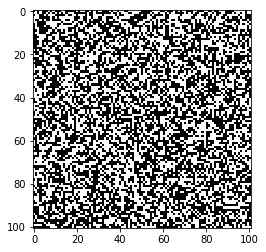

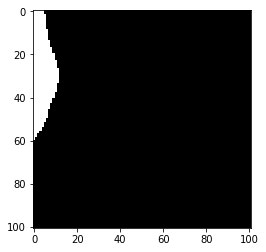

In [76]:
i = 11
j = 15
plt.figure(0)
plt.imshow(predicted[i][j].reshape(101, 101), cmap = "gray")
plt.figure(1)
plt.imshow(actual[i][j].reshape(101, 101), cmap = "gray")